In [1]:
# Importing required libraries
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Adding nodes
G.add_nodes_from(["Start", "Decision", "Action 1", "Action 2", "End"])

# Adding edges
G.add_edges_from([("Start", "Decision"),
                  ("Decision", "Action 1"),
                  ("Decision", "Action 2"),
                  ("Action 1", "End"),
                  ("Action 2", "End")])

labels = {
    ("Start", "Decision"): "Begin",
    ("Decision", "Action 1"): "Yes",
    ("Decision", "Action 2"): "No",
    ("Action 1", "End"): "",
    ("Action 2", "End"): "",
}

node_colors = ['skyblue' if n == 'Decision' else 'lightgray' for n in G.nodes]

# nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=2000, font_size=10, font_color='black', font_weight='bold', arrows=True)
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# Correcting the error and drawing the graph again with rounded corners for the rectangles

# Create a new figure and axis for larger size

pos = {
    "Start": (0, 2),
    "Decision": (1, 2),
    "Action 1": (1.5, 3),
    "Action 2": (1.5, 1),
    "End": (2, 2)
}

# nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=5000, font_size=10, font_color='black', font_weight='bold', node_shape='s', arrows=True)
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.show()

In [2]:
from sweepai.core.entities import FileChangeRequest

first_unit_test = FileChangeRequest(
    filename="a_test.py",
    instructions="Write unit tests",
    change_type="create",
    status="succeeded"
)

first_check = FileChangeRequest(
    filename="a_test.py", 
    instructions="Write unit tests",
    change_type="check",
    parent=first_unit_test,
    status="failed"
)

first_fix = FileChangeRequest(
    filename="a.py",
    instructions="Fix failed unit test",
    change_type="modify",
    parent=first_check,
    status="running"
)

file_change_requests = [
    first_unit_test,
    first_check,
    first_fix,
    FileChangeRequest(
        filename="a_test.py", 
        instructions="Fix failed unit test",
        change_type="check",
        parent=first_fix
    ),
    FileChangeRequest(
        filename="README.md", 
        instructions="Write unit tests",
        change_type="modify"
    ),
]

# print(file_change_requests)
print(first_check.id_)
print(file_change_requests[3].parent.id_)

2023-10-23 13:07:14.573 | INFO     | sweepai.config.server:<module>:195 - Using Sandbox URL: http://0.0.0.0:8081


bd6a0c66-5057-45cf-85ac-1fe15b525b75
b3ece7ac-5dd2-4a7a-bbfb-29451afbb9ee


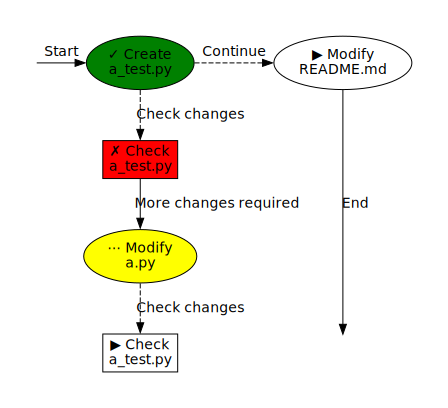

In [9]:
from graphviz import Digraph

dot = Digraph(comment='FileChangeRequest Tree')
fontname = "sans-serif"
dot.attr(fontname=fontname)
dot.attr(title="Tree\n\n")
dot.attr(pad="0.5")

ranks = {}

for i, fcr in enumerate(file_change_requests):
    if fcr.parent is None:
        ranks[fcr.id_] = 0
    else:
        ranks[fcr.id_] = ranks[fcr.parent.id_] + 1

for layer in range(max(ranks.values()) + 1):
    with dot.subgraph() as c:
        if layer == 0:
            c.attr(label="Original plan", labelloc="t", labeljust="l", rank="same", fontname=fontname)
            c.node('start', '', shape='none', width="0", fontname=fontname)
        else:
            c.attr(label=f"Layer {layer}", rank="same", fontname=fontname)
        if layer == max(ranks.values()):
            c.node('end', '', shape='none', width="0", fontname=fontname)
        for fcr in file_change_requests:
            if ranks[fcr.id_] == layer:
                if fcr.change_type == "check":
                    c.node(fcr.id_, fcr.summary, shape="rectangle", fillcolor=fcr.color, style="filled", fontname=fontname)
                else:
                    c.node(fcr.id_, fcr.summary, fillcolor=fcr.color, style="filled", fontname=fontname)

last_item_per_layer = {layer: None for layer in range(max(ranks.values()) + 1)}

for fcr in file_change_requests:
    if fcr.parent:
        if fcr.change_type == "check":
            dot.edge(fcr.parent.id_, fcr.id_, label="Check changes", style="dashed", fontname=fontname)
        elif fcr.parent.change_type == "check":
            dot.edge(fcr.parent.id_, fcr.id_, label="More changes required", fontname=fontname)
        else:
            dot.edge(fcr.parent.id_, fcr.id_)
    elif last_item_per_layer[ranks[fcr.id_]] is not None:
        dot.edge(last_item_per_layer[ranks[fcr.id_]].id_, fcr.id_, label="Continue", style="dashed", fontname=fontname)
    last_item_per_layer[ranks[fcr.id_]] = fcr

dot.edge('start', file_change_requests[0].id_, label="Start", fontname=fontname)
dot.edge(file_change_requests[-1].id_, 'end', label="End", fontname=fontname)

dot.format = "svg"
dot